The aim of this notebook is to check if the images can be preprocessed and saved
so that the same preprocessing aren't performed multiple times during pretraining 
(the number of images might be too large to fit in memory or store 
`monai.data.PersistentDataset` next to raw data).

### Imports

In [1]:
import sys 
sys.path.append('..')

In [2]:
import torch
import matplotlib.pyplot as plt
import monai.transforms as T

from pathlib import Path
from monai.data import DataLoader, Dataset, NibabelWriter
from src.transforms import IoUCropd

### Save processed images

First of all, we need to save already processed images. Let's pick a few
original images and process it.

In [3]:
data_unproc = [
    {
        'img': '../data/ssl/FLARETs_0047_0000.nii.gz'
    },
    {
        'img': '../data/ssl/FLARETs_0048_0000.nii.gz'
    },
    {
        'img': '../data/ssl/FLARETs_0049_0000.nii.gz'
    }
]

transforms_unproc = [
    T.LoadImaged(
        keys=['img']
    ),
    T.EnsureChannelFirstd(
        keys=['img']
    ),
    T.Orientationd(
        keys=['img'], 
        axcodes='RAS'
    ),
    T.Spacingd(
        keys=['img'], 
        pixdim=(1, 1, 2.5),
        mode=('bilinear')
    ),
    T.ScaleIntensityRanged(
        keys=['img'], 
        a_min=-500, a_max=500,
        b_min=0.0, b_max=1.0, clip=True
    ),
    T.CropForegroundd(
        keys=['img'], 
        source_key='img'
    ),
    T.SpatialPadd(
        keys=['img'], 
        spatial_size=(96, 96, 96)
    ),
    T.EnsureTyped(  
        keys=['img'], 
        track_meta=False
    )
]

/home/ditto/envs/sslct/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [4]:
ds_unproc = Dataset(data=data_unproc, transform=T.Compose(transforms_unproc))
loader_unproc = DataLoader(ds_unproc, batch_size=1)

In [5]:
writer = NibabelWriter()

for data in loader_unproc:
    load_path = Path(data['img_meta_dict']['filename_or_obj'][0])
    load_name = load_path.name.split('.')[0]
    save_path = load_path.parent / Path(f'{load_name}_processed.nii.gz')

    writer.set_data_array(data['img'][0], channel_dim=0)
    writer.write(save_path, verbose=False)

### First comparison

Now let's check if processing raw images gives same results as loading already
processed images.

In [6]:
data_proc = [
    {
        'img': '../data/ssl/FLARETs_0047_0000_processed.nii.gz'
    },
    {
        'img': '../data/ssl/FLARETs_0048_0000_processed.nii.gz'
    },
    {
        'img': '../data/ssl/FLARETs_0049_0000_processed.nii.gz'
    }
]

transforms_proc = [
    T.LoadImaged(
        keys=['img']
    ),
    T.EnsureChannelFirstd(
        keys=['img']
    ),
    T.EnsureTyped(  
        keys=['img'], 
        track_meta=False
    )
]

In [7]:
ds_proc = Dataset(data=data_proc, transform=T.Compose(transforms_proc))
loader_proc = DataLoader(ds_proc, batch_size=1)

In [8]:
for data_unproc, data_proc in zip(loader_unproc, loader_proc):
    s = (
        f'Comparing {Path(data_unproc["img_meta_dict"]["filename_or_obj"][0]).name} '
        f'with {Path(data_proc["img_meta_dict"]["filename_or_obj"][0]).name}'
    )
    print(s)
    
    assert torch.equal(data_unproc['img'], data_proc['img'])

Comparing FLARETs_0047_0000.nii.gz with FLARETs_0047_0000_processed.nii.gz
Comparing FLARETs_0048_0000.nii.gz with FLARETs_0048_0000_processed.nii.gz
Comparing FLARETs_0049_0000.nii.gz with FLARETs_0049_0000_processed.nii.gz


Saving preprocessed images works!

### Second comparison

We don't store (or might lose) some metadata. It shouldn't be needed further
but let's see that the images will still look the same even once augmented.

We'll now process the images simultaneously to make sure the random augmentations
are applied using the same values. 

In [10]:
data = [
    {
        'img_unproc': '../data/ssl/FLARETs_0047_0000.nii.gz',
        'img_proc': '../data/ssl/FLARETs_0047_0000_processed.nii.gz'
    },
    {
        'img_unproc': '../data/ssl/FLARETs_0048_0000.nii.gz',
        'img_proc': '../data/ssl/FLARETs_0048_0000_processed.nii.gz'
    },
    {
        'img_unproc': '../data/ssl/FLARETs_0049_0000.nii.gz',
        'img_proc': '../data/ssl/FLARETs_0049_0000_processed.nii.gz'
    }
]

In [11]:
transforms = [
    T.LoadImaged(
        keys=['img_unproc', 'img_proc']
    ),
    T.EnsureChannelFirstd(
        keys=['img_unproc', 'img_proc']
    ),
    T.Orientationd(
        keys=['img_unproc'], 
        axcodes='RAS'
    ),
    T.Spacingd(
        keys=['img_unproc'], 
        pixdim=(1, 1, 2.5),
        mode=('bilinear')
    ),
    T.ScaleIntensityRanged(
        keys=['img_unproc'], 
        a_min=-500, a_max=500,
        b_min=0.0, b_max=1.0, clip=True
    ),
    T.CropForegroundd(
        keys=['img_unproc'], 
        source_key='img_unproc'
    ),
    T.SpatialPadd(
        keys=['img_unproc'], 
        spatial_size=(96, 96, 96)
    ),
    T.EnsureTyped(  
        keys=['img_unproc', 'img_proc'], 
        track_meta=False
    ),
    T.RandZoomd(
        keys=['img_unproc', 'img_proc'], 
        min_zoom=0.8, 
        max_zoom=1.2, 
        mode=('trilinear', 'trilinear'),
        prob=1
    ),
    T.RandFlipd(
        keys=['img_unproc', 'img_proc'], 
        spatial_axis=1,
        prob=1
    ),
    IoUCropd(  # Adds '1' and '2' suffixes
        keys=['img_unproc', 'img_proc'], 
        min_iou=0.3, 
        max_iou=0.6
    )
]

In [12]:
ds = Dataset(data=data, transform=T.Compose(transforms))
loader = DataLoader(ds, batch_size=1)

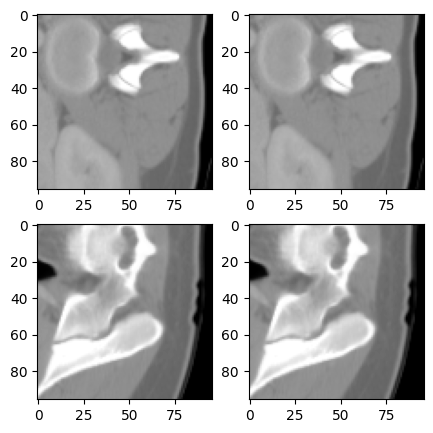

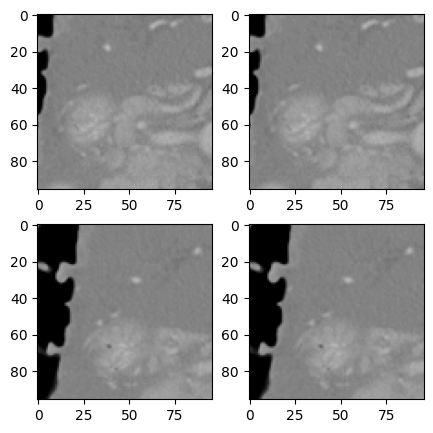

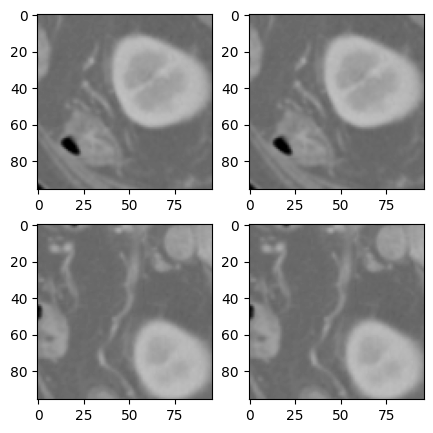

In [13]:
for data in loader:
    assert torch.equal(data['img_unproc1'], data['img_proc1'])
    assert torch.equal(data['img_unproc2'], data['img_proc2'])

    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    
    axs[0, 0].imshow(
        data['img_unproc1'][0, 0, :, :, 50].cpu(), 
        vmin=0, vmax=1, cmap='gray')
    axs[0, 1].imshow(
        data['img_proc1'][0, 0, :, :, 50].cpu(), 
        vmin=0, vmax=1, cmap='gray')
    axs[1, 0].imshow(
        data['img_unproc2'][0, 0, :, :, 50].cpu(),
        vmin=0, vmax=1, cmap='gray')
    axs[1, 1].imshow(
        data['img_proc2'][0, 0, :, :, 50].cpu(), 
        vmin=0, vmax=1, cmap='gray')
    
    plt.show()
    plt.close()

The metadata isn't needed for such augmentations. One can safely store
preprocessed images (although it's worth checking here for new augmentations).